In [1]:
import scipy.stats
import os
import csv
from scipy.special import erf, erfinv
import numpy as np
%matplotlib nbagg
import matplotlib.pyplot as plt

In [2]:
def ReadData(path='.', filename='showcases.2011.csv'):
    """Reads a CSV file of data.

    Args:
      filename: string filename

    Returns: sequence of (price1 price2 bid1 bid2 diff1 diff2) tuples
    """

    fullname = os.path.join(path, filename)
    fp = open(fullname)
    reader = csv.reader(fp)
    res = []

    for t in reader:
        _heading = t[0]
        data = t[1:]
        try:
            data = [int(x) for x in data]
            # print heading, data[0], len(data)
            res.append(data)
        except ValueError:
            pass

    fp.close()
    return list(zip(*res))

"""Reads data and makes player objects."""
data = ReadData(filename='./showcases.2011.csv')
data += ReadData(filename='showcases.2012.csv')

cols = zip(*data)
price1, price2, bid1, bid2, diff1, diff2 = np.array(cols)

<IPython.core.display.Javascript object>


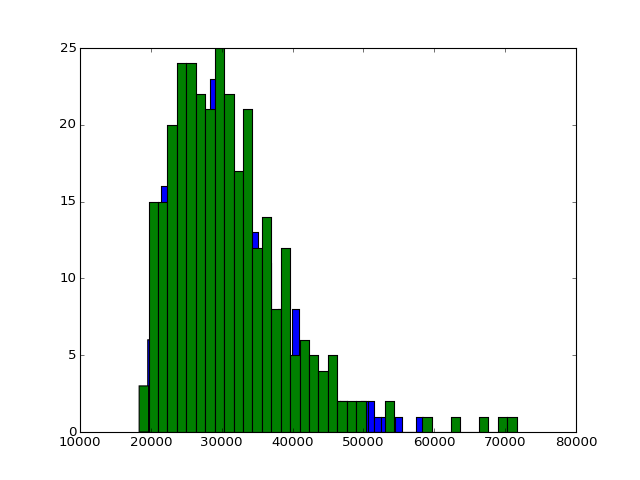

<IPython.core.display.Javascript object>


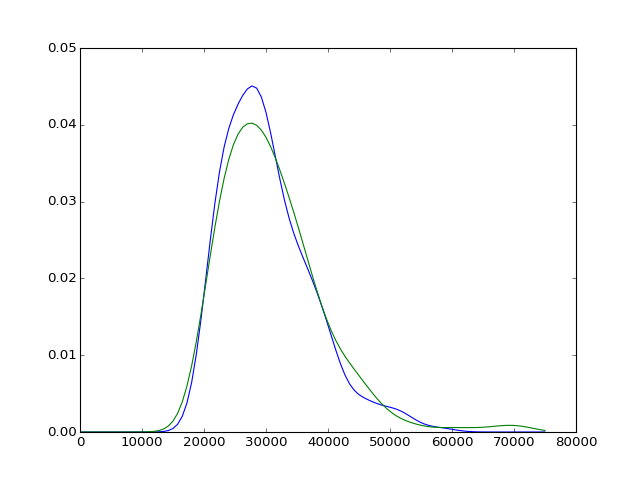

In [52]:

plt.figure()
plt.hist(price1,bins=40)
plt.hist(price2,bins=40)
N=101
x=np.linspace(0,75000,N)
dx=x[1]-x[0]
priceprior1 = scipy.stats.gaussian_kde(price1).evaluate(x)
priceprior2 = scipy.stats.gaussian_kde(price2).evaluate(x)

priceprior1=priceprior1/priceprior1.sum()
priceprior2=priceprior2/priceprior2.sum()

plt.figure()
plt.plot(x,priceprior1)
plt.plot(x,priceprior2)


<IPython.core.display.Javascript object>


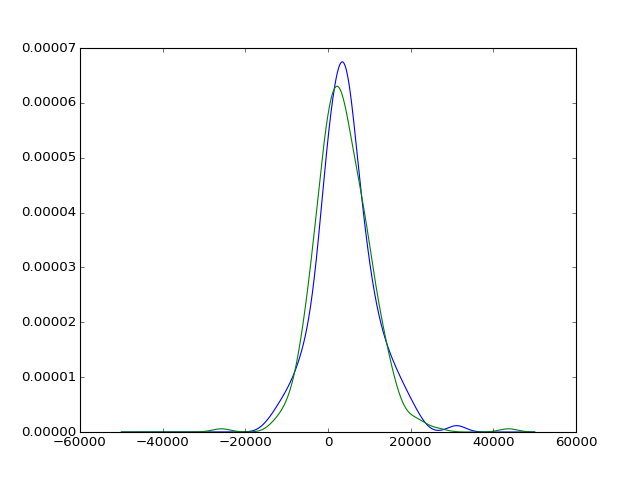

In [53]:

xdiff=np.linspace(-50000,50000,100000)
dxdiff=xdiff[1]-xdiff[0]
pricediff1o = scipy.stats.gaussian_kde(diff1)
pricediff2o = scipy.stats.gaussian_kde(diff2)

pricediff1 = pricediff1o.evaluate(xdiff)
pricediff2 = pricediff2o.evaluate(xdiff)

pricediff1cum=np.cumsum(pricediff1)*dxdiff
pricediff2cum=np.cumsum(pricediff2)*dxdiff

plt.figure()
plt.plot(xdiff,pricediff1)
plt.plot(xdiff,pricediff2)

In [54]:
pricepost1=np.zeros(priceprior1.shape)
pricepost2=np.zeros(priceprior2.shape)
guess1=20000
guess2=40000

for i in range(len(pricepost1)):
    pricepost1[i]=priceprior1[i]*pricediff1o.evaluate(x[i]-guess1)*dx
    pricepost2[i]=priceprior2[i]*pricediff2o.evaluate(x[i]-guess2)*dx
    
pricepost1=pricepost1/pricepost1.sum()
pricepost2=pricepost2/pricepost2.sum()

<IPython.core.display.Javascript object>


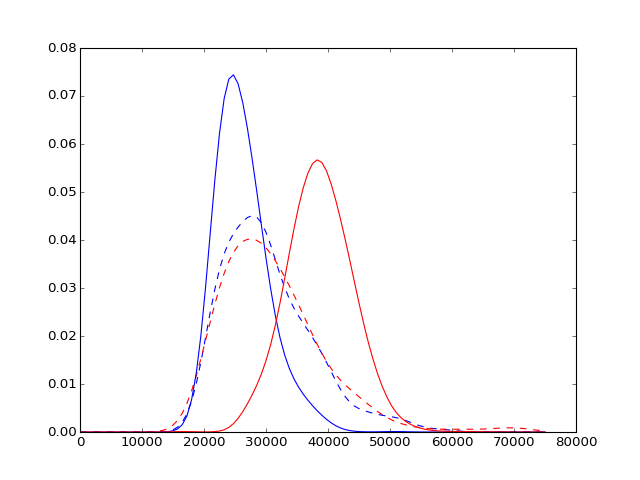

In [55]:
plt.figure()
plt.plot(x,priceprior1,'b--')
plt.plot(x,priceprior2,'r--')
plt.plot(x,pricepost1,'b-')
plt.plot(x,pricepost2,'r-')

0
50
100


C:\Anaconda\lib\site-packages\matplotlib\pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


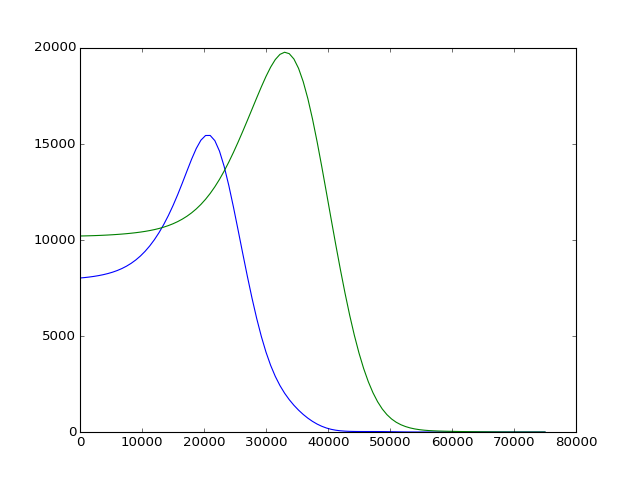

In [56]:
expectedgain1=np.zeros(priceprior1.shape)
expectedgain2=np.zeros(priceprior2.shape)

def gain(bid,price):
    gains=price*0
    mask=((price-bid)>250)
    gains[mask]=price[mask]
    
    mask=((price-bid)>0)*((price-bid)<=250)
    gains[mask]=2*price[mask]
    mask=((price-bid)<0)
    gains[mask]=0
    return gains

def probwin1(bid,price):
    probs=price*0
    base=pricediff2cum[np.argmin(np.abs(0-xdiff))]
    for i in range(len(price)):
        probs[i]=base+1-pricediff2cum[np.argmin(np.abs(xdiff-(price[i]-bid)))]
    return probs

def probwin2(bid,price):
    probs=price*0
    base=pricediff1cum[np.argmin(np.abs(0-xdiff))]
    for i in range(len(price)):
        probs[i]=base+1-pricediff1cum[np.argmin(np.abs(xdiff-(price[i]-bid)))]
    return probs
    

for i in range(len(expectedgain1)):
    if i%50==0:
        print i
    expectedgain1[i]=(gain(x[i],x)*probwin1(x[i],x)*pricepost1).sum()
    expectedgain2[i]=(gain(x[i],x)*probwin2(x[i],x)*pricepost2).sum()
    
plt.figure()
plt.plot(x,expectedgain1)
plt.plot(x,expectedgain2)



In [57]:
ind1=np.argmax(expectedgain1)
print "%g,%g"%(x[ind1],expectedgain1[ind1])
ind2=np.argmax(expectedgain2)
print "%g,%g"%(x[ind2],expectedgain2[ind2])

21000,15445.1
33000,19779
